In [1]:
import torch 
torch.cuda.empty_cache()
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /home/bohumil/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [2]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /home/bohumil/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [3]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [4]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

In [5]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [6]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [7]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [8]:
classes_to_labels = utils.get_coco_object_dictionary()

In [9]:
import pickle
with open ('outfile', 'rb') as fp:
    classes_to_labels = pickle.load(fp)

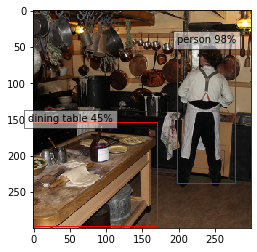

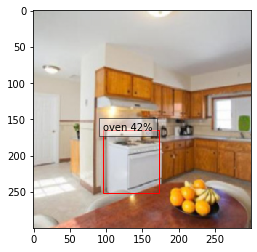

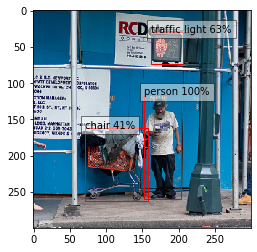

In [10]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [ ]:
torch.save(ssd_model.state_dict(), './SSD_orig_state.st')

In [ ]:
from src.model import SSD300 , ResNet

ssd_dist = SSD300()

In [ ]:
ssd_dist.load_state_dict(torch.load('./SSD_orig_state.st'))

In [ ]:
ssd_dist.to('cuda')
ssd_dist.eval()

In [ ]:
def detect(model, tensor):
    with torch.no_grad():
        detections_batch = model(tensor)
    return detections_batch

In [ ]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [ ]:
import os
import torch
from distiller.data_loggers import collect_quant_stats, QuantCalibrationStatsCollector
import distiller

#man_model = torch.load('./manual.checkpoint.pth.tar')
distiller.utils.assign_layer_fq_names(ssd_dist)
collector = QuantCalibrationStatsCollector(ssd_dist)

stats_file = './acts_quantization_stats.yaml'

if not os.path.isfile(stats_file):
    def eval_for_stats(model):
        detect(ssd_dist, tensor)
#         eval_model(data_loader=train_loader_cpu,model=model)
    collect_quant_stats(ssd_dist, eval_for_stats, save_dir='.')

In [ ]:
from copy import deepcopy
from distiller.quantization import PostTrainLinearQuantizer
import argparse
import os

def make_quantizer(cpu_model, config_file_path):
    """returns stats_before_prepare, quantizer"""
    parser = argparse.ArgumentParser()
    distiller.quantization.add_post_train_quant_args(parser)
    args = parser.parse_args(args=[])
    
    #this needs to be defined in config file
    # args.qe_stats_file = os.path.expanduser(stats_file)
    
    #config present, ALL OTHER args are IGNORED
    args.qe_config_file = os.path.expanduser(config_file_path)
    
    cp = deepcopy(cpu_model)
    quantizer = PostTrainLinearQuantizer.from_args(cp, args)
    
    # Quantizer magic
    stats_before_prepare = deepcopy(quantizer.model_activation_stats)
    
    # dummy input of (batch_size, height, width, depth)
    # https://towardsdatascience.com/understanding-input-and-output-shapes-in-convolution-network-keras-f143923d56ca
    dummy_input = (torch.zeros(1,3,300,300) )

    quantizer.prepare_model(dummy_input)
    
    return stats_before_prepare, quantizer



In [ ]:
ssd_model.to('cpu')

In [ ]:
[uris[0]]

In [ ]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

In [ ]:
tensor.shape

In [ ]:
stats_file = '/home/bohumil/FIIT/BP/BP/Zdroje_kod/quantization_jupyters/SSD/acts_quantization_stats.yaml'
config_file = '/home/bohumil/FIIT/BP/BP/Zdroje_kod/quantization_jupyters/SSD/ssd_coco_post_train.yaml'
stats_before_quantization, quantizer = make_quantizer(ssd_dist,config_file)
quantizer.model

In [ ]:
quantizer.model.eval()
detection_batch = detect(quantizer.model, tensor)

In [ ]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [ ]:
stats_file = '/home/bohumil/FIIT/BP/BP/Zdroje_kod/quantization_jupyters/SSD/acts_quantization_stats.yaml'
config_file = '/home/bohumil/FIIT/BP/BP/Zdroje_kod/quantization_jupyters/SSD/ssd_coco_post_train_4bit.yaml'
stats_before_quantization, quantizer_4bit = make_quantizer(ssd_dist,config_file)
quantizer_4bit.model

In [ ]:
model = quantizer_4bit.model
model.eval()
detection_batch = detect(model, tensor)
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [ ]:
import distiller

torch.cuda.empty_cache()
stats_file = '/home/bohumil/FIIT/BP/BP/Zdroje_kod/quantization_jupyters/SSD/acts_quantization_stats.yaml'
config_file = '/home/bohumil/FIIT/BP/BP/Zdroje_kod/quantization_jupyters/SSD/ssd_coco_post_train_2bit.yaml'
stats_before_quantization, quantizer_2bit = make_quantizer(ssd_dist,config_file)
model = quantizer_2bit.model
model.eval()
model.to('cuda')
detections_batch = detect(model, tensor)
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

In [ ]:
detections_batch

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()